# Unet
The model design includes two learning stages. In stage I, each input volume goes through a separate stack of convolutional layers. In stage II, feature maps resulting from stage I are merged, and the results are fed to a deep learning model to arrive at the final outputs.

![title](img/f1.png)

In [1]:
#!pip install tensorflow xarray numpy wget
#!wget https://raw.githubusercontent.com/pazolka/sun-et-al-2019/main/stages.py
#!wget https://raw.githubusercontent.com/pazolka/sun-et-al-2019/main/unet.py

import numpy as np
import xarray as xr

from keras.models import Model
from keras.optimizers import SGD
import tensorflow as tf
from stages import stage1
from unet import unet
from full_models import unet_full

2024-06-10 17:08:57.083765: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 17:08:57.122682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1. Shallow learning (Stage 1)
For Unet and SegnetLite models, stage I shallow learning includes a single convolutional layer with 16 filters for each type of predictors, the outputs of which are then merged and provided as inputs to the respective deep learning model.

In [2]:
stage1_model = stage1(16)

stage1_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                              

#### 2. Unet

In [3]:
unet_model = unet((128,128,48))

In [4]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 48)]       0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 128, 128, 32)         13856     ['input_4[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d_3[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_4[0][0]']            
 D)                                                                                         

#### 3. Combined model (Stage 2)

In [5]:
full_model = Model(inputs=stage1_model.inputs, outputs=unet_model(stage1_model.outputs))
#full_model = unet_full(16)

In [6]:
full_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                            

In [7]:
# Define the custom loss function
def custom_loss(data, y_pred):
    y_true = data[:,:,:,0][..., np.newaxis]

    # Mean Squared Error (MSE)
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)

    # Nash-Sutcliffe Efficiency (NSE) component
    numerator = tf.reduce_sum(tf.abs(y_pred - y_true))
    denominator = tf.reduce_sum(tf.abs(y_true - tf.reduce_mean(y_true, axis=0)))
    nse = numerator / (denominator + tf.keras.backend.epsilon())

    # Combine MSE and NSE
    combined_loss = 0.5 * mse + 0.5 * nse
    return combined_loss

In [8]:
# Define the custom metrics
def custom_nse(data, y_pred):
    y_true = data[:, :, :, 0][..., np.newaxis]
    grace_true = data[:, :, :, 1][..., np.newaxis]
    gldas_true = data[:, :, :, 2][..., np.newaxis]
    spatial_mean_per_ex_grace = tf.reduce_mean(grace_true, axis=(1,2))
    spatial_mean_per_ex_gldas = tf.reduce_mean(gldas_true, axis=(1,2))
    spatial_mean_per_ex_pred = tf.reduce_mean(y_pred, axis=(1,2))
    numerator = tf.reduce_sum(tf.square(spatial_mean_per_ex_grace - spatial_mean_per_ex_gldas + spatial_mean_per_ex_pred))
    denominator = tf.reduce_sum(tf.square(spatial_mean_per_ex_grace - tf.reduce_mean(spatial_mean_per_ex_grace, axis=0)))
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

def pearson_r(data, y_pred):
    y_true = data[:,:,:,0][..., np.newaxis]
    my_true = tf.reduce_mean(y_true)
    my_pred = tf.reduce_mean(y_pred)
    y_true_m, y_pred_m = y_true - my_true, y_pred - my_pred
    r_num = tf.reduce_sum(y_true_m * y_pred_m)
    y_true_square_sum = tf.reduce_sum(y_true_m * y_true_m)
    y_pred_square_sum = tf.reduce_sum(y_pred_m * y_pred_m)
    r_den = tf.sqrt(y_true_square_sum * y_pred_square_sum)
    r = r_num / (r_den + tf.keras.backend.epsilon())
    return r

In [9]:
full_model.compile(optimizer = SGD(learning_rate = 0.01, weight_decay=1e-6, momentum=0.9, clipnorm=1.0), loss = custom_loss, metrics = [ custom_nse, pearson_r ])

In [10]:
full_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                            

#### 4. Model training
Out of a total of 177 monthly data available for the study period, 125 months or 70% is used for training and the rest for testing.

In [11]:
precip_train = np.array([np.load(f'./data/processed_input/precip/image_{i}.npy') for i in range(3,127)])
temp_train = np.array([np.load(f'./data/processed_input/temp/image_{i}.npy') for i in range(3,127)])
twsa_train = np.array([np.load(f'./data/processed_input/twsa/image_{i}.npy') for i in range(3,127)])

precip_test = np.array([np.load(f'./data/processed_input/precip/image_{i}.npy') for i in range(127,177)])
temp_test = np.array([np.load(f'./data/processed_input/temp/image_{i}.npy') for i in range(127,177)])
twsa_test = np.array([np.load(f'./data/processed_input/twsa/image_{i}.npy') for i in range(127,177)])

mismatch_ds = xr.open_mfdataset('./data/mismatch.nc4')
mismatch = mismatch_ds['norm_mismatch'].to_numpy()[..., np.newaxis]
grace = mismatch_ds['grace'].to_numpy()[..., np.newaxis]
gldas = mismatch_ds['gldas'].to_numpy()[..., np.newaxis]

mismatch_train = mismatch[3:127]
mismatch_test = mismatch[127:177]
grace_train = grace[3:127]
grace_test = grace[127:177]
gldas_train = gldas[3:127]
gldas_test = gldas[127:177]

print(f'Number of training examples = {precip_train.shape[0]}')
print(f'Number of test examples = {precip_test.shape[0]}')

print(f'Training input shape: {precip_train.shape}')
print(f'Training output shape: {mismatch_train.shape}')
print(f'Test input shape: {precip_test.shape}')
print(f'Test output shape: {mismatch_test.shape}')

Number of training examples = 124
Number of test examples = 50
Training input shape: (124, 128, 128, 3)
Training output shape: (124, 128, 128, 1)
Test input shape: (50, 128, 128, 3)
Test output shape: (50, 128, 128, 1)


In [12]:
full_model.fit(x=[precip_train, temp_train, twsa_train], y=np.concatenate((mismatch_train, grace_train, gldas_train), axis = 3), epochs = 60, batch_size = 5)

Epoch 1/60
25/25 [==============================] - 18s 604ms/step - loss: 0.9072 - custom_nse: -0.8145 - pearson_r: 0.2818
Epoch 2/60
25/25 [==============================] - 14s 571ms/step - loss: 0.7278 - custom_nse: -1.9703 - pearson_r: 0.4346
Epoch 3/60
25/25 [==============================] - 15s 615ms/step - loss: 0.7000 - custom_nse: 0.6760 - pearson_r: 0.4653
Epoch 4/60
25/25 [==============================] - 17s 678ms/step - loss: 0.6879 - custom_nse: 0.4617 - pearson_r: 0.4923
Epoch 5/60
25/25 [==============================] - 14s 580ms/step - loss: 0.6864 - custom_nse: 0.4587 - pearson_r: 0.5025
Epoch 6/60
25/25 [==============================] - 15s 597ms/step - loss: 0.6693 - custom_nse: 0.5065 - pearson_r: 0.5077
Epoch 7/60
25/25 [==============================] - 16s 633ms/step - loss: 0.6802 - custom_nse: 0.3541 - pearson_r: 0.5203
Epoch 8/60
25/25 [==============================] - 14s 565ms/step - loss: 0.6433 - custom_nse: 0.6371 - pearson_r: 0.5410
Epoch 9/60
25/

In [13]:
preds = full_model.evaluate([precip_test, temp_test, twsa_test], np.concatenate((mismatch_test, grace_test, gldas_test), axis=3), batch_size=5)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10/10 [==============================] - 2s 145ms/step - loss: 1.3837 - custom_nse: -4.0447 - pearson_r: 0.7563
Loss = 1.383665919303894
Test Accuracy = -4.044699668884277


In [14]:
pred_mismatch = full_model.predict([precip_test, temp_test, twsa_test], batch_size=5)

10/10 [==============================] - 2s 147ms/step


In [15]:
pred_mismatch.shape

(50, 128, 128, 1)

In [16]:
mismatch_ds = xr.open_mfdataset('./data/mismatch.nc4')

In [17]:
pred_mismatch_da = xr.DataArray(np.squeeze(pred_mismatch), coords={'time': mismatch_ds['time'][127:177],'lat': mismatch_ds['lat'], 'lon': mismatch_ds['lon']}, dims=['time', 'lat', 'lon'])

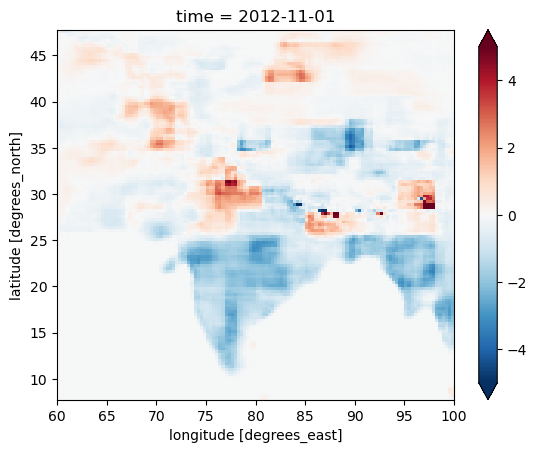

In [18]:
pred_mismatch_da[0,:,:].plot(vmin=-5, vmax=5, cmap='RdBu_r')

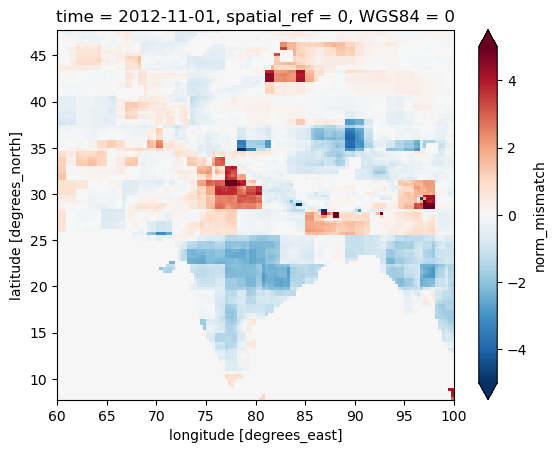

In [19]:
mds = mismatch_ds.transpose('time', 'lat', 'lon')
mds['norm_mismatch'][127,:,:].plot(vmin=-5, vmax=5, cmap='RdBu_r')

##### 5. Save

In [20]:
full_pred_mismatch = full_model.predict([
    np.concatenate((precip_train, precip_test), axis=0),
    np.concatenate((temp_train, temp_test), axis=0),
    np.concatenate((twsa_train, twsa_test))
    ], batch_size=5)

full_pred_mismatch_da = xr.DataArray(np.squeeze(full_pred_mismatch), coords={'time': mismatch_ds['time'][3:177],'lat': mismatch_ds['lat'], 'lon': mismatch_ds['lon']}, dims=['time', 'lat', 'lon'])
full_pred_mismatch_da.to_dataset(name='norm_prediction').to_netcdf('./data/unet_output.nc4')

35/35 [==============================] - 5s 140ms/step
